In [1]:
!pip install matplotlib --quiet

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models,datasets
from torch.utils.data import DataLoader
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

trainset = datasets.CIFAR10(
    root= './data',
    train=True,
    download=True,
    transform=transform
)

testset = datasets.CIFAR10(
    root ='./data',
    train=False,
    download=True,
    transform=transform
)

batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset,batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


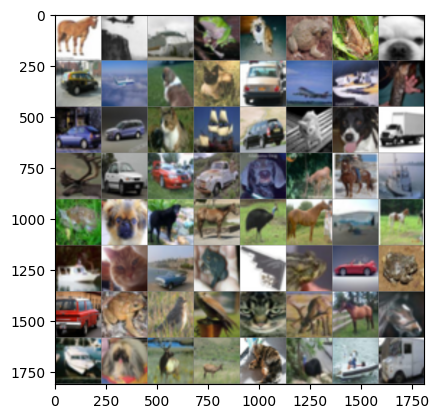

In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [6]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
print(vgg16)

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
vgg16.classifier[6].out_features = 10

for param in vgg16.features.parameters():
    param.requires_grad = False


In [8]:
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [9]:
def validate(model, test_dataloader, criterion):
    model.eval()
    top1_correct = 0
    top5_correct = 0
    total_samples = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_running_loss += loss.item() * target.size(0)  # accumulate the total loss

            # Calculate top-1 and top-5 accuracy
            _, top5_preds = output.topk(5, dim=1, largest=True, sorted=True)
            top5_preds = top5_preds.t()  

            top1_correct += top5_preds[:1].eq(target.view(1, -1)).sum().item()
            top5_correct += top5_preds.eq(target.view(1, -1)).sum().item()
            total_samples += target.size(0)

    top1_accuracy = 100. * top1_correct / total_samples
    top5_accuracy = 100. * top5_correct / total_samples
    val_loss = val_running_loss / total_samples  # calculate average validation loss

    print(f'Validation Loss: {val_loss:.4f}, Top-1 Acc: {top1_accuracy:.2f}, Top-5 Acc: {top5_accuracy:.2f}')
    return val_loss, top1_accuracy, top5_accuracy

In [10]:
def fit(model, train_dataloader, criterion, optimizer):
    model.train()
    train_running_loss = 0.0
    top1_correct = 0
    top5_correct = 0
    total_samples = 0

    for data, target in train_dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Accumulate the total loss
        train_running_loss += loss.item() * target.size(0)

        # Calculate top-1 and top-5 accuracy
        _, top5_preds = output.topk(5, dim=1, largest=True, sorted=True)
        top5_preds = top5_preds.t()
        
        top1_correct += top5_preds[:1].eq(target.view(1, -1)).sum().item()
        top5_correct += top5_preds.eq(target.view(1, -1)).sum().item()
        total_samples += target.size(0)

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / total_samples  # average train loss
    top1_accuracy = 100. * top1_correct / total_samples
    top5_accuracy = 100. * top5_correct / total_samples

    print(f'Train Loss: {train_loss:.4f}, Top-1 Acc: {top1_accuracy:.2f}, Top-5 Acc: {top5_accuracy:.2f}')
    return train_loss, top1_accuracy, top5_accuracy

In [11]:
train_loss, train_top1_accuracy, train_top5_accuracy = [], [], []
val_loss, val_top1_accuracy, val_top5_accuracy = [], [], []

start = time.time()
for epoch in range(2000):
    train_epoch_loss, train_top1_acc, train_top5_acc = fit(vgg16, trainloader, criterion, optimizer)
    val_epoch_loss, val_top1_acc, val_top5_acc = validate(vgg16, testloader, criterion)
    
    train_loss.append(train_epoch_loss)
    train_top1_accuracy.append(train_top1_acc)
    train_top5_accuracy.append(train_top5_acc)
    val_loss.append(val_epoch_loss)
    val_top1_accuracy.append(val_top1_acc)
    val_top5_accuracy.append(val_top5_acc)

end = time.time()

torch.save(vgg16.state_dict(), 'vgg16.pth')
print(f"Training took {(end - start) / 60:.2f} minutes")

# Print final statistics
print(f"Final Train Loss: {train_loss[-1]:.4f}, Top-1 Acc: {train_top1_accuracy[-1]:.2f}, Top-5 Acc: {train_top5_accuracy[-1]:.2f}")
print(f"Final Val Loss: {val_loss[-1]:.4f}, Top-1 Acc: {val_top1_accuracy[-1]:.2f}, Top-5 Acc: {val_top5_accuracy[-1]:.2f}")

Train Loss: 1.0122, Top-1 Acc: 68.68, Top-5 Acc: 95.52
Train Loss: 0.5527, Top-1 Acc: 81.06, Top-5 Acc: 99.20
Train Loss: 0.5565, Top-1 Acc: 80.28, Top-5 Acc: 99.22
Train Loss: 0.4875, Top-1 Acc: 83.37, Top-5 Acc: 99.34
Train Loss: 0.4654, Top-1 Acc: 83.78, Top-5 Acc: 99.48
Train Loss: 0.4474, Top-1 Acc: 84.36, Top-5 Acc: 99.45
Train Loss: 0.4043, Top-1 Acc: 85.82, Top-5 Acc: 99.64
Train Loss: 0.4224, Top-1 Acc: 85.42, Top-5 Acc: 99.60
Train Loss: 0.3568, Top-1 Acc: 87.46, Top-5 Acc: 99.72
Train Loss: 0.4098, Top-1 Acc: 85.79, Top-5 Acc: 99.55
Train Loss: 0.3132, Top-1 Acc: 88.95, Top-5 Acc: 99.78
Train Loss: 0.4005, Top-1 Acc: 86.25, Top-5 Acc: 99.57
Train Loss: 0.2728, Top-1 Acc: 90.56, Top-5 Acc: 99.84
Train Loss: 0.3925, Top-1 Acc: 86.91, Top-5 Acc: 99.59
Train Loss: 0.2383, Top-1 Acc: 91.75, Top-5 Acc: 99.88
Train Loss: 0.3956, Top-1 Acc: 86.69, Top-5 Acc: 99.61
Train Loss: 0.2099, Top-1 Acc: 92.77, Top-5 Acc: 99.91
Train Loss: 0.3912, Top-1 Acc: 87.00, Top-5 Acc: 99.62
Train Loss

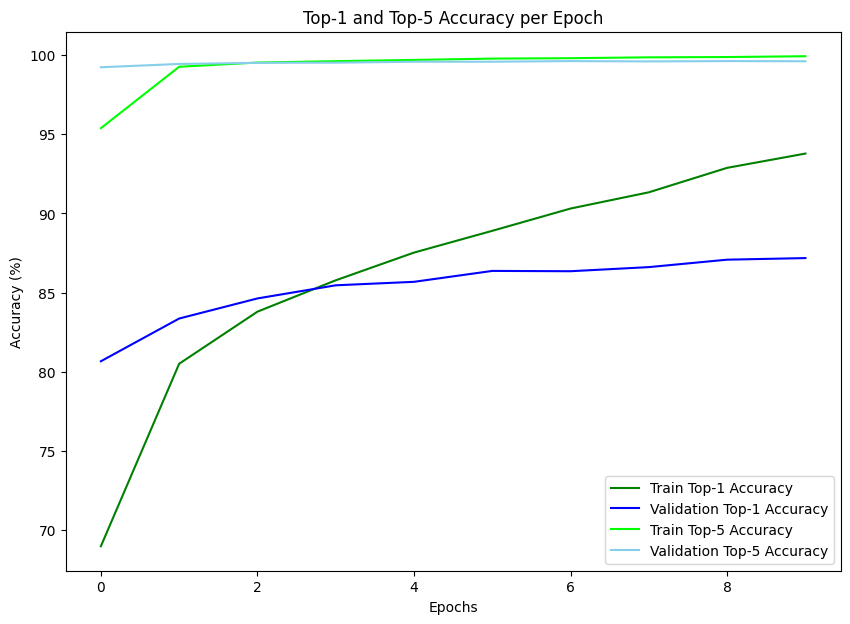

In [13]:
plt.figure(figsize=(10, 7))

# Plot Top-1 Accuracies
plt.plot(train_top1_accuracy, color='green', label='Train Top-1 Accuracy')
plt.plot(val_top1_accuracy, color='blue', label='Validation Top-1 Accuracy')

# Plot Top-5 Accuracies
plt.plot(train_top5_accuracy, color='lime', label='Train Top-5 Accuracy')
plt.plot(val_top5_accuracy, color='skyblue', label='Validation Top-5 Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Top-1 and Top-5 Accuracy per Epoch')
plt.legend()
plt.savefig('accuracy.png')
plt.show()